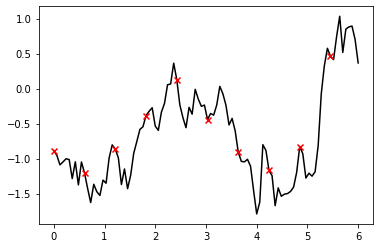

In [19]:
import numpy as np
from matplotlib import pyplot as plt

def ou_cov(sigma, gamma, t, t_):
    
    coeff = 0.5 * sigma ** 2 / gamma
    exp = np.exp(- gamma * np.abs(t[..., :, None] - t_[..., None, :]))
    
    return coeff * exp


t0 = 0.
t1 = 6.

sigma = 1.
gamma = 1.

num_pts = 100

np.random.seed(0)

t = np.linspace(t0, t1, num_pts)
x_mean = np.zeros((num_pts,))
x_cov = ou_cov(sigma=sigma, gamma=gamma, t=t, t_=t)

x = np.random.multivariate_normal(mean=x_mean, cov=x_cov)

plt.plot(t, x, color='k', zorder=1)
plt.scatter(t[::10], x[::10], marker='x', color='red', zorder=2)

In [32]:
def forward(b, A, Sigma, dt):
    
    for i in range(len(b) - 1):
        
        m[i + 1] = m[i] + (- np.dot(A[i], m[i]) + b[i]) * dt
        S[i + 1] = S[i] + (- np.dot(A[i], S[i]) - np.dot(S[i], A[i].T) + Sigma) * dt
        
    return m, S


def backward(b, A, psi, lamda):
    pass

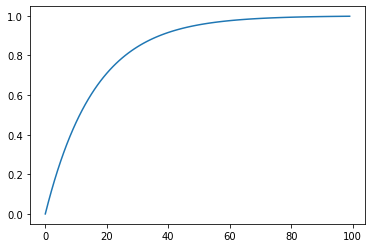

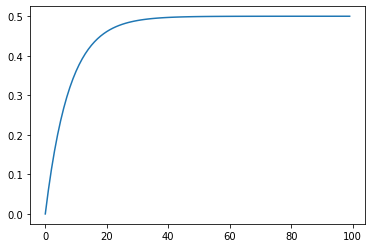

In [43]:
b = np.ones((num_pts, 1))
A = np.ones((num_pts, 1, 1))

lamda = np.zeros((num_pts, 1))
psi = np.zeros((num_pts, 1, 1))

m = np.zeros((num_pts, 1))
S = np.zeros((num_pts, 1, 1))

Sigma = sigma * np.eye(1)
dt = (t1 - t0) / num_pts

m_, S_ = forward(b=b, A=A, Sigma=Sigma, dt=dt)


plt.plot(m[:, 0])
plt.show()
plt.plot(S[:, 0, 0])
plt.show()